In [1]:
#importing all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from gensim.models import KeyedVectors
from sklearn.preprocessing import LabelEncoder
import pickle
import random
from keras.models import model_from_json
import seaborn as sns

In [2]:
random.seed(666)

Loading the dataset

In [3]:
df = pd.read_csv("new_complaints3.csv") 

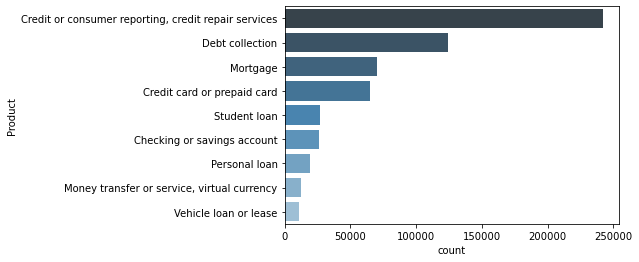

In [4]:
ax = sns.countplot(y="Product", data=df, palette=("Blues_d"), order=df['Product'].value_counts().index)

plt.savefig("catcount.pgf",dpi=150, bbox_inches = "tight")
plt.savefig("catcount.png",dpi=150, bbox_inches = "tight")
plt.show()

The data splited into feature and target.

In [5]:
X_data = df['new']
y_data = df['Product']

In [6]:
X_data

0         transworld systems inc \nis trying to collect ...
1         Over the past 2 weeks I have been receiving ex...
2         Pioneer has committed several federal violatio...
3         Previously on XX XX XXXX XX XX XXXX and XX XX ...
4         Hello This complaint is against the three cred...
                                ...                        
597869    1  Mailing Address is incorrect \n2  Date of B...
597870    I made a purchase of ##### on XXXX XXXX #### u...
597871    On XXXX XXXX #### I contacted XXXX XXXX who is...
597872    I can not get from chase who services my mortg...
597873    cfbp i would Like to file a complaint on Exper...
Name: new, Length: 597874, dtype: object

The DataFrame converted to a NumPy array.

In [7]:
X = X_data.values
y = y_data.values

The data splitted into train and test set, the train set is 80 percent of the data, and the test set is 20 percent. The data is stratified based on the label.

In [8]:
X_train_value, X_val_value, y_train_value, y_val_value = train_test_split(X, y, 
                                                                          test_size=0.4, 
                                                                          random_state=666, 
                                                                          stratify=y)

Vocabulary was built based on the unique words from the train set.

In [9]:
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(X_train_value)

In [10]:
vocab = tokenizer.word_index

In [11]:
vocab_size = len(vocab)

In [12]:
vocab_size

159487

Creating an empty weight matrix for words in document vocabulary, +1 because the word index dictionary value starting from 1

In [ ]:
embedding_matrix = np.zeros((vocab_size+1, 300))

Fill in the embedding matrix

In [ ]:
vectors = KeyedVectors.load('vectors.kv')

In [ ]:
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = vectors[word]
        embedding_matrix[i] = embedding_vector
    except:
        embedding_vector = vectors['UNK']
        embedding_matrix[i] = embedding_vector

In [13]:
X_train = tokenizer.texts_to_sequences(X_train_value)
X_val = tokenizer.texts_to_sequences(X_val_value)

Sanity check

In [14]:
len(X_val_value[1].split())

106

In [15]:
X_val_value[7]

'I previously tried to settle this matter with experian about unauthorized inquiries on my consumer report i sent them a letter explaining the problem trying to get experian to resolve the issue but they never did On XX XX #### i sent out another letter certified about the unauthorized inquiries on my consumer report and i still have not got a response I requested there method of verification about these inquires and i never received anything from experian i will send a copy of the certified letter that i sent to experian on XX XX ####'

In [16]:
len(X_val[1])

106

The sequences of words padded and limited to 200 sequences per instances.

In [17]:
X_train = pad_sequences(X_train, maxlen=200, truncating='post', padding='post')
X_val = pad_sequences(X_val, maxlen=200, truncating='post', padding='post')

The label converted to one-hot encoding

In [18]:
enc = LabelEncoder()
y_train_label = enc.fit_transform(y_train_value)
y_val_label = enc.transform(y_val_value)

In [19]:
print(enc.classes_)
print(np.unique(y_train_label, return_counts=True))
print(np.unique(y_val_label, return_counts=True))

['Checking or savings account' 'Credit card or prepaid card'
 'Credit or consumer reporting, credit repair services' 'Debt collection'
 'Money transfer or service, virtual currency' 'Mortgage' 'Personal loan'
 'Student loan' 'Vehicle loan or lease']
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 15516,  38824, 145461,  74649,   7690,  42251,  11619,  16220,
         6494], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([10344, 25882, 96974, 49767,  5126, 28168,  7746, 10813,  4330],
      dtype=int64))


In [20]:
y_train = to_categorical(np.asarray(y_train_label))
y_val = to_categorical(np.asarray(y_val_label))
print('Shape of data:', X_train.shape)
print('Shape of label:', y_train.shape)
print('Shape of label:', y_val.shape)

Shape of data: (358724, 200)
Shape of label: (358724, 9)
Shape of label: (239150, 9)


Split the data further for validation and test

In [22]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=666, stratify=y_val)

In [23]:
print('training/validation/test')
print(str(X_train.shape[0]) + '/' + str(X_val.shape[0]) + '/' + str(X_test.shape[0]))


training/validation/test
358724/119575/119575


Function to evaluate the test set

In [30]:
from keras.models import model_from_json

def evaluate_model(model_json, weight_h5):
    json_file = open(model_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weight_h5)
    print("Model loaded")

    # evaluate loaded model on test data
    loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    score = loaded_model.evaluate(X_test, y_test, verbose=1)
    print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
    
    return score[1]*100


In [31]:
lstm = evaluate_model('model_1_rnn.json', 'model_1_rnn.h5')
cnn = evaluate_model('model_2_cnn2.json', 'model_2_cnn2.h5')
lstm_w2v = evaluate_model('model_3_rnn_w2v.json', 'model_3_rnn_w2v.h5')
cnn_w2v = evaluate_model('model_4_cnn_w2v2.json', 'model_4_cnn_w2v2.h5')

Model loaded
3737/3737 [==============================] - 252s 67ms/step - loss: 0.4407 - accuracy: 0.8487
accuracy: 84.87%
Model loaded
3737/3737 [==============================] - 92s 25ms/step - loss: 0.5246 - accuracy: 0.8341
accuracy: 83.41%
Model loaded
3737/3737 [==============================] - 260s 69ms/step - loss: 0.4516 - accuracy: 0.8471s - loss: 0.4516 - ac
accuracy: 84.71%
Model loaded
3737/3737 [==============================] - 85s 23ms/step - loss: 0.5599 - accuracy: 0.8221
accuracy: 82.21%


In [32]:
results = pd.DataFrame({'Model': ['LSTM', 'LSTM Word2Vec', 'CNN', 'CNN Word2Vec' ],
                   'Accuracy': [str(round(lstm,2)), str(round(lstm_w2v,2)), 
                                str(round(cnn,2)), str(round(cnn_w2v,2))],
                   })
print(results.to_latex(index=False)) 

\begin{tabular}{ll}
\toprule
         Model & Accuracy \\
\midrule
          LSTM &    84.87 \\
 LSTM Word2Vec &    84.71 \\
           CNN &    83.41 \\
  CNN Word2Vec &    82.21 \\
\bottomrule
\end{tabular}



Function to create classification report dataframe

In [33]:
def df_classification_report(pred_model, classifier):
    report = classification_report(np.argmax(y_test, axis=-1),pred_model, 
                                   target_names=df['Product'].unique(), output_dict=True)
    report = pd.DataFrame(report).transpose()
    report['classifier'] = classifier
    report.reset_index(inplace=True)
    report = report.rename(columns = {'index':'categories'})
    return report

In [37]:
lstm_report = df_classification_report(lstm_pred, 'LSTM')
lstm_w2v_report = df_classification_report(lstm_w2v_pred, 'LSTM W2V')
cnn_report = df_classification_report(cnn_pred, 'CNN')
cnn_w2v_report = df_classification_report(cnn_w2v_pred, 'CNN W2V')

In [38]:
lstm_report

,categories,precision,recall,f1-score,support,classifier
0,Debt collection,0.759079,0.816319,0.786659,5172.000000,LSTM
1,"Credit or consumer reporting, credit repair se...",0.811710,0.823816,0.817718,12941.000000,LSTM
2,"Money transfer or service, virtual currency",0.895154,0.892920,0.894035,48487.000000,LSTM
3,Mortgage,0.819396,0.841096,0.830104,24883.000000,LSTM
4,Vehicle loan or lease,0.834035,0.696059,0.758826,2563.000000,LSTM
5,Student loan,0.920728,0.922820,0.921773,14084.000000,LSTM
6,Credit card or prepaid card,0.541820,0.531887,0.536808,3873.000000,LSTM
7,Checking or savings account,0.846058,0.877196,0.861346,5407.000000,LSTM
8,Personal loan,0.603211,0.364434,0.454362,2165.000000,LSTM
9,accuracy,0.848672,0.848672,0.848672,0.848672,LSTM


In [52]:
frames = [lstm_report, lstm_w2v_report, cnn_report, cnn_w2v_report]

In [53]:
merged_report = pd.concat(frames, axis=0)
merged_report = merged_report[~merged_report['categories'].isin(['accuracy', 'macro avg', 'weighted avg'])]
merged_report = merged_report.reset_index(inplace=False)
merged_report = merged_report.drop(['index'], axis=1)

In [54]:
merged_report[['precision','recall']] = merged_report[['precision','recall']].mul(100)

In [56]:
merged_report.to_csv(r'merged_report.csv', index = False)

In [182]:
merged_report = pd.read_csv('merged_report.csv')

In [195]:
merged.drop(['pop'], axis=1)

,categories,precision,recall,f1-score,support,classifier
0,Debt collection,75.907947,81.631864,0.786659,5172.0,LSTM
1,"Credit or consumer reporting, credit repair se...",81.171007,82.381578,0.817718,12941.0,LSTM
2,"Money transfer or service, virtual currency",89.515362,89.291975,0.894035,48487.0,LSTM
3,Mortgage,81.939551,84.109633,0.830104,24883.0,LSTM
4,Vehicle loan or lease,83.403460,69.605931,0.758826,2563.0,LSTM
5,Student loan,92.072825,92.282022,0.921773,14084.0,LSTM
6,Credit card or prepaid card,54.182009,53.188743,0.536808,3873.0,LSTM
7,Checking or savings account,84.605780,87.719623,0.861346,5407.0,LSTM
8,Personal loan,60.321101,36.443418,0.454362,2165.0,LSTM
9,Debt collection,79.281603,77.242846,0.782489,5172.0,LSTM W2V


In [61]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [190]:
def result_plot(evaluation):
    g = sns.catplot(x="classifier", y=evaluation, col="categories",
                    col_wrap=3, hue="classifier", dodge=False,
                    data=merged_report, saturation=.9,
                    kind="bar", ci=None, aspect=.9)
    (g.set_axis_labels("", "Score")
      .set_titles("{col_name}", size=14)
      .set(ylim=(0, 1), xticklabels=[])
      .despine(left=True)  
      .add_legend())
    sns.color_palette("colorblind")
    #plt.show()
    #g.savefig("precision.png",dpi=300, bbox_inches = "tight")
    g.savefig("f1.pgf",dpi=150, bbox_inches = "tight")

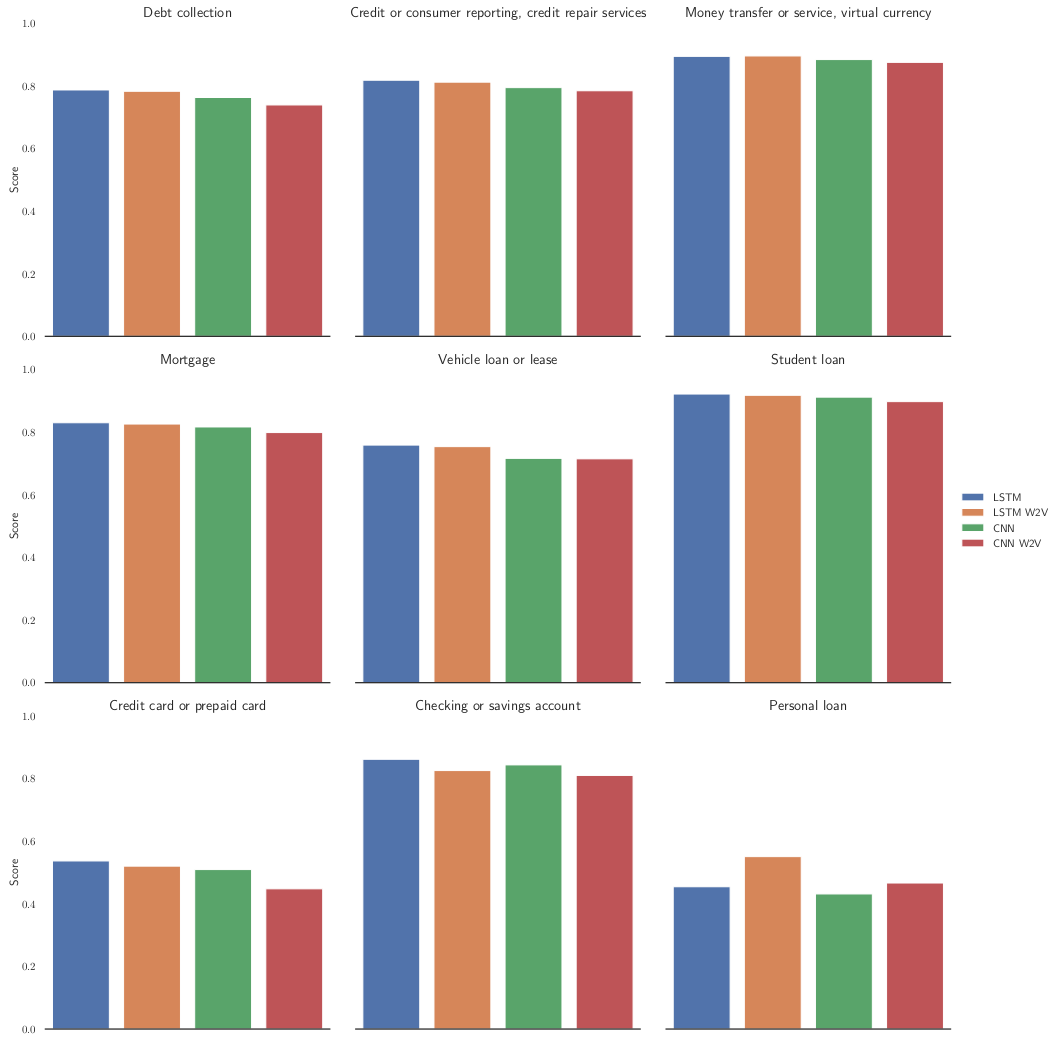

In [191]:
result_plot('f1-score')

In [165]:
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [166]:
# Use tex for all labels globally in the plot
sns.set(rc={'text.usetex': True}, style='white')

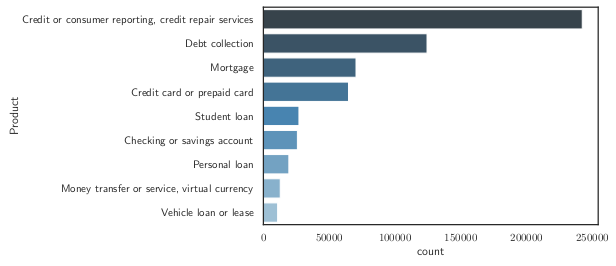

In [167]:
ax = sns.countplot(y="Product", data=df,palette=("Blues_d"), order=df['Product'].value_counts().index)
plt.savefig("catcount.pgf",dpi=150, bbox_inches = "tight")
plt.savefig("catcount.png",dpi=150, bbox_inches = "tight")
#plt.show()

In [5]:
def return_prediction(model_json, weight_h5):
    json_file = open(model_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weight_h5)
    print("Model loaded")
    pred_model = np.argmax(loaded_model.predict(X_test), axis=-1)
    return pred_model

In [29]:
lstm_pred = return_prediction('model_1_rnn.json', 'model_1_rnn.h5')
cnn_pred = return_prediction('model_2_cnn2.json', 'model_2_cnn2.h5')
lstm_w2v_pred = return_prediction('model_3_rnn_w2v.json', 'model_3_rnn_w2v.h5')
cnn_w2v_pred = return_prediction('model_4_cnn_w2v2.json', 'model_4_cnn_w2v2.h5')

Model loaded
Model loaded
Model loaded
Model loaded


In [173]:
plt.rcParams["axes.grid"] = False

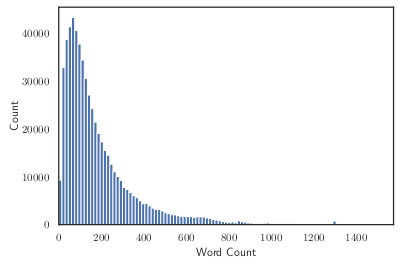

In [181]:
df['word_count'].hist(bins = 100, range=[0,1500])
plt.xlim(xmin = 0)
plt.xlabel("Word Count")
plt.ylabel("Count")
plt.grid(None) 
plt.savefig("wordcount.pgf",dpi=150, bbox_inches = "tight")
plt.savefig("wordcount.png",dpi=150, bbox_inches = "tight")

In [204]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def print_confusion_matrix(pred, true):
    conf_mat = confusion_matrix((np.argmax(true, axis=-1)), pred)
    fig, ax = plt.subplots(figsize=(5,3))
    fig.set_size_inches(w=5, h=3)
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Reds',xticklabels=df['Product'].unique(),
                yticklabels=df['Product'].unique())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    #plt.show()
    plt.savefig('cm_lstm_w2v.pgf',dpi=100, bbox_inches = "tight")
    plt.savefig("cm_lstm_w2v.png",dpi=100, bbox_inches = "tight")

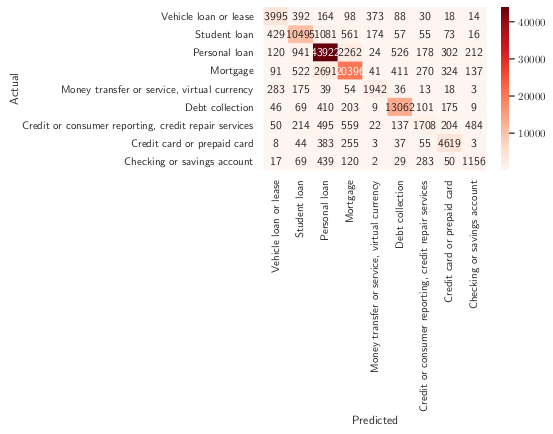

In [205]:
print_confusion_matrix(lstm_w2v_pred, y_test)

Function to return the trained model

In [31]:
from keras.models import model_from_json

def load_model(model_json, weight_h5):
    json_file = open(model_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weight_h5)
    print("Model loaded")
    return loaded_model

In [32]:
lstm_model = load_model('model_1_rnn.json', 'model_1_rnn.h5') 
cnn_model = load_model('model_2_cnn2.json', 'model_2_cnn2.h5')
lstm_w2v_model = load_model('model_3_rnn_w2v.json', 'model_3_rnn_w2v.h5')
cnn_w2v_model = load_model('model_4_cnn_w2v2.json', 'model_4_cnn_w2v2.h5')

Model loaded
Model loaded
Model loaded
Model loaded
